In [ ]:
from fastai.vision.all import *
from fastai.vision.gan import *
import seaborn as sns
import sys
import torch

In [3]:
run_as_standalone_nb = False

In [4]:
if run_as_standalone_nb:
    root_lib_path = Path('face2anime').resolve()
    if not root_lib_path.exists():
        !git clone https://github.com/davidleonfdez/face2anime.git
    if str(root_lib_path) not in sys.path:
        sys.path.insert(0, str(root_lib_path))
else:
    import local_lib_import

In [5]:
from face2anime.gen_utils import is_iterable
from face2anime.layers import (ConcatPoolHalfDownsamplingOp2d, ConvHalfDownsamplingOp2d,
                               ConvX2UpsamplingOp2d, InterpConvUpsamplingOp2d, TransformsLayer)
from face2anime.losses import CritPredsTracker, LossWrapper, R1GANGPCallback
from face2anime.nb_utils import mount_gdrive
from face2anime.networks import res_critic, res_generator
from face2anime.train_utils import (add_ema_to_gan_learner, custom_load_model,
                                    custom_save_model)
from face2anime.transforms import AdaptiveAugmentsCallback, ADATransforms

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 64
n_channels = 3
bs = 64
save_cycle_len = 5

In [ ]:
# Optional, allows saving parameters in gdrive
# root_gdrive = mount_gdrive()

# Data

## Target ds

animecharacterfaces, by Kaggle user *aadilmalik94*

In [ ]:
# anime_ds_zip_path = Path(root_gdrive)/"ML/animeface-character-dataset.zip"
# !cp "{anime_ds_zip_path}" .
# !unzip animeface-character-dataset.zip >> /.tmpA
# !rm animeface-character-dataset.zip

In [7]:
anime_ds_path = Path('./animeface-character-dataset/data')
#anime_ds_path = Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data').resolve()
#target_fns = get_image_files(celeba_path)
# get_image_files is too slow, there's no need to check the extension here
target_fns = anime_ds_path.ls()
target_fns

(#9754) [Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data/face_326_318_9.png'),Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data/face_110_472_32.png'),Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data/face_227_208_47.png'),Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data/face_265_227_38.png'),Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data/face_332_186_7.png'),Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data/face_379_379_15.png'),Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data/face_697_165_78.png'),Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data/face_1139_94_83.png'),Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data/face_157_268_64.png'),Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data/face_332_187_21.png')...]

---

In [8]:
normalize_tf = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5]))
normalize_imagenet_tf = Normalize.from_stats(*imagenet_stats)

def get_dblock(extra_batch_tfms=None):
    if extra_batch_tfms is None: extra_batch_tfms = []
    return DataBlock(blocks=(TransformBlock, ImageBlock),
                   get_x=generate_noise,
                   #get_items=get_image_files,
                   get_items=lambda path: target_fns,
                   splitter=IndexSplitter([]),
                   item_tfms=Resize(img_size, method=ResizeMethod.Crop), 
                   batch_tfms=[normalize_tf] + extra_batch_tfms)

dblock = get_dblock()
main_path = anime_ds_path
dls = dblock.dataloaders(main_path, path=main_path, bs=bs)

In [ ]:
dls.show_batch()

# Evaluation

In [10]:
base_fid_samples_path = Path('./fid_samples')
n_fid_imgs = 10000

def download_pytorch_fid_calculator():        
    #!git clone https://github.com/mseitzer/pytorch-fid.git
    !pip install pytorch-fid

def create_fid_dirs(base_fid_samples_path):
    base_fid_samples_path.mkdir()
    (base_fid_samples_path/'fake').mkdir()
    (base_fid_samples_path/'real').mkdir()
        
def predict_n(learner, n_imgs, max_bs=64):
    dummy_path = Path('')
    dl = learner.dls.test_dl([dummy_path]*n_imgs, bs=max_bs)   
    inp, imgs_t, _, dec_imgs_t = learner.get_preds(dl=dl, with_input=True, with_decoded=True)
    dec_batch = dls.decode_batch((inp,) + tuplify(dec_imgs_t), max_n=n_imgs)
    return dec_batch
    
def predict_show_n(learner, n_imgs, **predict_n_kwargs):
    preds_batch = predict_n(learner, n_imgs, **predict_n_kwargs)
    _, axs = plt.subplots(n_imgs, 2, figsize=(6, n_imgs * 3))
    for i, (inp, pred_img) in enumerate(preds_batch):
        inp.show(ax=axs[i][0])
        pred_img.show(ax=axs[i][1])
        
def save_real_imgs(dls, n_imgs=10000, use_input_ds=False):
    n_imgs_left = n_imgs
    while n_imgs_left > 0:
        b = dls.one_batch()
        bs = b[1].size()[0]
        dec_b = dls.decode_batch(b, max_n=bs)
        for i in range(bs):
            if n_imgs_left == 0: break
            tuple_idx = 0 if use_input_ds else 1
            img_t = dec_b[i][tuple_idx]
            img = PILImage.create(img_t)
            img_idx = n_imgs_left-1
            img.save(base_fid_samples_path/f'real/{img_idx}.jpg')
            #if n_imgs_left % 1000 == 0: print("saved " + str(img_idx))
            n_imgs_left -= 1

def save_fake_imgs(learner, n_imgs=10000, **predict_n_kwargs):
    base_path = base_fid_samples_path
    preds_batch = predict_n(learner, n_imgs, **predict_n_kwargs)
    for i, (inp, img) in enumerate(preds_batch):
        PILImage.create(img).save(base_path/f'fake/{i}.jpg')
        
def eval_models(builders, n_epochs, base_path='./models',
                fn_suffix='', ema=False):
    assert is_iterable(builders) or is_iterable(n_epochs)
    if not is_iterable(builders): 
        builders = [builders] * len(list(n_epochs))
    if not is_iterable(n_epochs): 
        n_epochs = [n_epochs] * len(list(builders))
    for builder, n_ep in zip(builders, n_epochs):
        #model_id = builder.__name__.split('_')[-1]
        learner = builder(for_inference=True)
        custom_load_model(learner, f'noise2anime{fn_suffix}_{n_ep}ep', with_opt=False,
                          base_path=base_path, with_ema=ema)
        if ema: 
            learner = Learner(learner.dls, learner.ema_model,
                              loss_func=lambda *args: torch.tensor(0.))
        save_fake_imgs(learner, n_imgs=n_fid_imgs)
        print(f'---- after {n_ep} epochs ----')
        !python -m pytorch_fid {base_fid_samples_path/'fake'} {base_fid_samples_path/'real'}

------------------

# Training

In [12]:
class SaveCheckpointsCallback(Callback):
    "Callback that saves the model at the end of each epoch."
    def __init__(self, learn, fn_prefix, base_path=Path('.'), initial_epoch=1,
                 save_cycle_len=1):
        self.fn_prefix = fn_prefix
        self.base_path = base_path
        self.epoch = initial_epoch
        self.save_cycle_len = save_cycle_len
        
    def after_epoch(self):
        if (self.epoch % self.save_cycle_len) == 0:
            fn = f'{self.fn_prefix}_{self.epoch}ep'
            custom_save_model(learn, fn, base_path=self.base_path)
        self.epoch += 1
        

def save_preds(c_preds_tracker, filepath):
    return c_preds_tracker.to_df().to_csv(filepath)


def plot_c_preds(c_preds_tracker):
    preds_xs = range(len(c_preds_tracker.real_preds))
    sns.lineplot(x=preds_xs, y=c_preds_tracker.fake_preds.cpu(), label='Fake preds')
    ax=sns.lineplot(x=preds_xs, y=c_preds_tracker.real_preds.cpu(), label='Real preds')
    ax.set_xlabel('Number of batches')
    ax.set_ylabel('Critic preds')
    
    
def plot_smooth_c_preds(c_preds_tracker):
    preds_xs = range(len(c_preds_tracker.real_preds))    
    smooth_real_preds = c_preds_tracker.real_preds.cpu()
    smooth_fake_preds = c_preds_tracker.fake_preds.cpu()
    for i in range(1, len(smooth_real_preds)):
        smooth_real_preds[i] = smooth_real_preds[i-1] * 0.9 + smooth_real_preds[i] * 0.1
        smooth_fake_preds[i] = smooth_fake_preds[i-1] * 0.9 + smooth_fake_preds[i] * 0.1
    sns.lineplot(x=preds_xs, y=smooth_fake_preds, label='EMA fake preds')    
    ax=sns.lineplot(x=preds_xs, y=smooth_real_preds, label='EMA real preds')
    ax.set_xlabel('Number of batches')
    ax.set_ylabel('Critic preds')

First, we will train our GAN to:

1. Assess its potential with a small training set (~10k images)
2. Check if the ADA heuristic is applicable. This can be confirmed by looking at the discriminator outputs: after some iterations of training, we should see an increasing divergence in the predictions for real and fake images, leading to a point where the generator doesn't improve and FID gets worse and worse because the discriminator has overfitted to the training set.

Then, if ADA is indeed applicable, we'll try with ADA and adjust its parameters.

## 1. Train without augmentation

In [12]:
class LossStore(Callback):
    def __init__(self):
        self.g_losses = []
        self.c_losses = []

    def after_epoch(self):
        #if not self.training: return        
        # self.training is already false here even when training.
        # An alternative is to disable cb when not needed:
        #      `with learn.removed_cbs(...): ...`
        self.g_losses.append(self.gan_trainer.gen_loss.value.item())
        self.c_losses.append(self.gan_trainer.crit_loss.value.item())    


def create_learner(for_inference=False, gp_w=1., c_loss_interceptors=None):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128, flatten_full=True)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    if not for_inference:
        cbs.append(R1GANGPCallback(weight=gp_w))
    def gen_loss_func(*args): return 0
    crit_loss_func = nn.BCEWithLogitsLoss()
    loss_G, loss_C = gan_loss_from_func(gen_loss_func, crit_loss_func)
    loss_C = LossWrapper(loss_C, c_loss_interceptors)
    
    learn = GANLearner(dls, generator, critic, loss_G, loss_C,
                       opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                       cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                       switch_eval=False)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    add_ema_to_gan_learner(learn, dblock, main_path, decay=0.999)
    return learn

In [13]:
c_preds_tracker = CritPredsTracker(reduce_batch=True)
learn = create_learner(c_loss_interceptors=[c_preds_tracker])
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4
# learn.model.generator, learn.model.critic

In [ ]:
# custom_load_model(learn, 'noise2anime_200ep', base_path='../input/noise2anime-weights/', with_ema=True)
# preds_df = pd.read_csv(io.StringIO(preds_csv_str), index_col=0)
# c_preds_tracker.load_from_df(preds_df, device)
# with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
#     displayable_learn.show_results(ds_idx=0)

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

In [ ]:
save_preds(c_preds_tracker, Path('noise2anime_crit_preds_200ep.csv'))

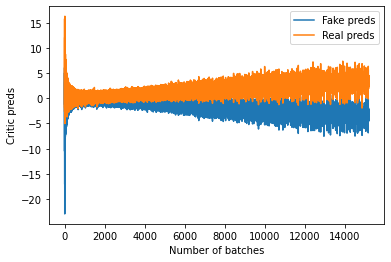

In [19]:
plot_c_preds(c_preds_tracker)

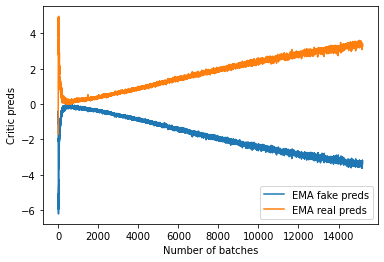

In [20]:
plot_smooth_c_preds(c_preds_tracker)

The following FID values have been obtained after executing code of appendix A:

In [21]:
epochs = list(range(5, 201, 5))
fids_lr2e4 = ([226.9, 169.4, 96.9, 84.9, 75.3, 62.3, 54.5, 43.2, 48.4, 42.2, 40.3, 35.9, 36.3, 31.0, 32.7, 37.9, 29.3, 32.7, 28.4, 30.9] 
                   + [28.8, 23.4, 30.6, 31.7, 34.9, 29.2, 28.6, 28.5, 31.5, 30.9, 28.0, 25.4, 27.9, 28.0, 34.9, 24.2, 26.8, 27.4, 28.3, 30.4])
# 201-230 no ema with lr=5e-5: [25.0, 22.4, 23.9, 24.6, 23.7, 23.2]
fids_lr2e4_ema = ([313.2, 342.7, 307.4, 279.9, 119.5, 88.2, 58.9, 50.5, 45.0, 40.7, 32.1, 31.2, 29.3, 27.8, 26.7, 26.1, 25.4, 24.5, 23.8, 22.9] 
                + [20.9, 20.7, 20.6, 20.2, 20.2, 20.1, 20.0, 20.0, 19.2, 19.7, 20.2, 20.3, 19.5, 19.6, 19.8, 19.8, 20.0, 20.3, 20.8, 20.6])
# 201-230 with ema and lr=5e-5: [19.8, 20.4, 20.7, 21.0, 21.6, 21.1]

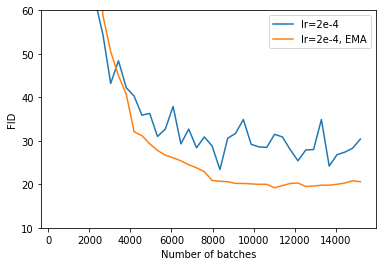

In [22]:
start_ep = 0
end_ep = min(len(fids_lr2e4), len(fids_lr2e4_ema))
losscmp_xs = range(start_ep, end_ep)
# Divide by 2 because we only track preds when training critic
n_crit_batches_by_epoch = math.ceil(len(dls.dataset) / bs) // 2
xs_batches = [ep * n_crit_batches_by_epoch for ep in epochs]
sns.lineplot(x=xs_batches, y=fids_lr2e4[start_ep:end_ep], label='lr=2e-4')
ax=sns.lineplot(x=xs_batches, y=fids_lr2e4_ema[start_ep:end_ep], label='lr=2e-4, EMA')
ax.set_xlabel('Number of batches')
ax.set_ylabel('FID')
ax.set_ybound(10, 60)
# #plt.legend(title='...')

We can see that FID stops going down after approximately half of training, which is the point when the overlap between the distribution of real and fake preds is becoming minimal, about less than 10%.

In [ ]:
loss_xs = range(len(learn.loss_store.c_losses))
sns.lineplot(x=loss_xs, y=learn.loss_store.c_losses, label='C loss')
ax=sns.lineplot(x=loss_xs, y=learn.loss_store.g_losses, label='G loss')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Loss')

A higher learning rate isn't of any help, as shown below:

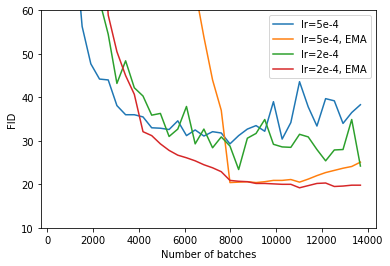

In [23]:
epochs = list(range(5, 181, 5))
fids_lr1e3 = ([190.2, 144.5, 95.4, 72.0, 59.5, 52.0, 53.9, 43.4, 45.2, 49.4, 38.3, 41.9, 35.8, 36.4, 37.4, 37.8, 43.6, 44.9, 42.2, 45.0]
                 + [])
fids_lr1e3_ema = ([346.1, 198.4, 242.7, 285.1, 263.4, 295.2, 300.6, 284.5, 35.5, 36.1, 34.0, 31.9, 30.7, 29.8, 28.9, 28.4, 25.3, 25.2, 25.6, 25.4]
                     + [])
fids_lr5e4 = ([162.1, 128.5, 79.4, 56.3, 47.7, 44.2, 44.0, 38.1, 36.0, 36.0, 35.5, 33.0, 32.9, 32.6, 34.6, 31.2, 32.5, 31.1, 32.1, 31.8]
                 + [29.3, 31.2, 32.7, 33.5, 32.2, 39.0, 30.4, 34.2, 43.6, 37.8, 33.4, 39.7, 39.2, 34.0, 36.5, 38.3])
fids_lr5e4_ema = ([375.4, 245.7, 220.7, 234.6, 176.5, 179.8, 173.2, 175.7, 168.5, 157.3, 154.1, 149.3, 128.6, 111.2, 89.1, 74.4, 64.7, 53.9, 44.0, 37.0]
                     + [20.4, 20.5, 20.6, 20.4, 20.6, 20.9, 20.9, 21.1, 20.5, 21.2, 22.0, 22.7, 23.2, 23.7, 24.1, 25.1])
start_ep = 0
end_ep = min(len(fids_lr5e4_ema), len(fids_lr5e4))
losscmp_xs = range(start_ep, end_ep)
# Divide by 2 because we only track preds when training critic
n_crit_batches_by_epoch = math.ceil(len(dls.dataset) / bs) // 2
xs_batches = [ep * n_crit_batches_by_epoch for ep in epochs]
sns.lineplot(x=xs_batches, y=fids_lr5e4[start_ep:end_ep], label='lr=5e-4')
sns.lineplot(x=xs_batches, y=fids_lr5e4_ema[start_ep:end_ep], label='lr=5e-4, EMA')
sns.lineplot(x=xs_batches, y=fids_lr2e4[start_ep:end_ep], label='lr=2e-4')
ax=sns.lineplot(x=xs_batches, y=fids_lr2e4_ema[start_ep:end_ep], label='lr=2e-4, EMA')
ax.set_xlabel('Number of batches')
ax.set_ylabel('FID')
ax.set_ybound(10, 60)
# #plt.legend(title='...')

## 2. Train with augmentations but not ADA (fixed p)

**Transformations ranked by effectiveness**
* ZoomOut 
* Translation
* ZoomIn TranslationX TranslationY  
* CutOut CutMix
* Brightness Redness Greenness MixUp: depending on arch and ds, range from noticeable improvements to almost neutral
* InstanceNoise: bad

From Image augmentations for GAN training, 3.2:
> Operations like translation, zoomin, and zoomout, are much more effective than operations like brightness, colorness, and mixup. We conclude that augmentations that result in spatial changes improve the GAN performance more than those that induce mostly visual changes.

From Image augmentations for GAN training, 3.2:
> Different from augmenting real images, we keep the gradients for augmented
> generated images to train the generator

bCR adds an independent regularization term, so in theory the regular loss is still calculated always with not augmented images.

In constrast, NVIDIA method only passes augmented images to the discriminator, but any augmentation technique is performed with a certain probability lower than 1:

> Our solution is similar to bCR in that we also apply a set of augmentations to all images shown to the discriminator. However, instead of adding separate CR loss terms, we evaluate the discriminator only using augmented images, and do this also when training the generator (Figure 2b).

> We always use the same value of p for all transformations. The randomization is done separately for each augmentation and for each image in a minibatch.

In [ ]:
def create_learner_2(for_inference=False, c_loss_interceptors=None, p=0.8,
                     tfms_selector=None):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128, flatten_full=True)
    ada_tfms = ADATransforms(p)
    tfms_array = ada_tfms.to_array()
    if tfms_selector is not None: tfms_array = tfms_selector(tfms_array)
    aug_critic = nn.Sequential(TransformsLayer(setup_aug_tfms(tfms_array)),
                               critic)
    
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    if not for_inference:
        # Pass critic to avoid grid_sample 2nd order derivative issue with aug_critic
        cbs.append(R1GANGPCallback(weight=1., critic=critic))
    def gen_loss_func(*args): return 0
    crit_loss_func = nn.BCEWithLogitsLoss()
    loss_G, loss_C = gan_loss_from_func(gen_loss_func, crit_loss_func)
    loss_C = LossWrapper(loss_C, c_loss_interceptors)
    
    learn = GANLearner(dls, generator, aug_critic, loss_G, loss_C,
                       opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                       cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                       switch_eval=False)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    add_ema_to_gan_learner(learn, dblock, main_path, decay=0.999)
    learn.ada_tfms = ada_tfms
    return learn

In [ ]:
c_preds_tracker = CritPredsTracker(reduce_batch=True)
learn = create_learner_2(c_loss_interceptors=[c_preds_tracker], p=0.3)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4
# learn.model.generator, learn.model.critic

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0) # 

In [ ]:
save_preds(c_preds_tracker, Path('noise2anime_crit_preds_p03_200ep.csv'))

In [ ]:
plot_c_preds(c_preds_tracker)

In [ ]:
plot_smooth_c_preds(c_preds_tracker)

In [24]:
fids_tr2_p06 =     ([286.1, 247.9, 225.5, 183.2, 187.2, 156.2, 181.7, 153.1, 139.3, 143.9, 123.0, 125.1, 138.2, 122.2, 132.2, 133.4, 133.4, 123.6, 113.6, 108.8] 
                   + [104.0, 116.7, 104.0, 91.2, 102.3, 103.1, 93.3, 95.8, 105.8, 92.0, 90.7, 90.0, 92.3, 99.0, 103.8, 87.9, 91.0, 96.3, 92.1, 105.7])
fids_tr2_p06_ema = ([337.3, 440.6, 383.4, 314.9, 280.6, 292.3, 229.8, 208.3, 155.4, 154.6, 150.5, 144.0, 142.6, 139.2, 138.4, 133.2, 129.5, 120.0, 113.1, 111.9] 
                   + [96.6, 97.8, 100.7, 98.2, 97.7, 88.7, 87.4, 90.3, 92.0, 96.9, 93.9, 90.9, 92.0, 97.1, 102.9, 100.2, 95.2, 92.4, 94.9, 92.2])
fids_tr2_p03 = ([269.6, 281.0, 221.0, 190.2, 222.9, 195.1, 179.0, 153.6, 146.6, 142.9, 135.8, 158.1, 123.2, 124.1, 139.5, 104.5, 112.3, 127.8, 133.8, 117.1]
               + [120.9, 120.5, 105.4, 96.8, 108.4, 111.4, 93.7, 103.0, 96.0, 95.8, 113.0, 81.0, 83.0, 92.5, 89.1, 91.7, 87.1, 93.0, 83.5, 76.0]
               + [75.0, 89.6, 90.2, 76.1, 86.7, 82.7, 94.5, 78.5, 75.5, 93.2])
fids_tr2_p03_ema = ([381.5, 425.5, 354.2, 370.3, 338.4, 262.4, 259.5, 257.7, 168.9, 191.2, 212.8, 197.1, 179.8, 166.7, 155.6, 155.1, 148.4, 135.6, 126.9, 114.9]
                   + [94.6, 105.6, 128.7, 133.1, 123.7, 116.8, 107.4, 104.4, 105.1, 96.1, 87.1, 90.8, 130.8, 101.5, 99.6, 91.5, 80.1, 77.2, 79.8, 78.2]
                   + [74.5, 75.4, 76.7, 77.9, 78.2, 79.5, 75.1, 82.7, 82.0, 73.5])
fids_tr2_p03_no_co = ([270.2, 246.2, 226.9, 196.5, 226.1, 214.8, 186.8, 178.5, 186.6, 185.6, 176.3, 182.6, 173.3, 164.6, 167.9, 179.8, 163.0, 149.8, 141.9, 141.1]
                     + [157.2, 136.9, 156.0, 145.2, 132.5, 129.9, 116.0, 128.7, 135.9, 118.1, 108.3, 113.8, 125.8, 109.2, 114.1, 118.4, 132.1, 140.3, 126.5, 133.3])
fids_tr2_p03_ema_no_co = ([361.6, 363.2, 324.6, 316.7, 243.8, 220.0, 232.8, 246.0, 200.5, 200.7, 206.3, 199.4, 194.0, 181.9, 180.1, 180.4, 172.1, 165.2, 156.5, 151.0]
                         + [147.8, 155.8, 157.1, 149.3, 150.6, 140.2, 131.1, 126.1, 128.1, 128.3, 129.3, 133.3, 128.1, 120.0, 115.9, 126.1, 141.7, 146.7, 136.9, 141.8])
fids_tr2_p01 = ([285.8, 237.4, 197.0, 195.9, 158.2, 135.8, 128.5, 87.7, 93.4, 92.6, 92.3, 86.3, 100.0, 85.4, 92.2, 92.4, 79.5, 90.4, 66.7, 92.6]
                + [67.8, 73.8, 75.5, 57.3, 68.9, 79.0, 68.5, 63.3, 73.8, 72.6, 67.8, 76.5, 62.0, 66.5, 63.5, 75.8, 89.4, 87.8, 64.2, 68.0])
fids_tr2_p01_ema = ([377.3, 338.8, 281.8, 269.8, 218.7, 216.5, 205.7, 213.8, 125.1, 127.8, 121.1, 116.6, 111.1, 104.1, 100.0, 98.3, 77.0, 85.6, 86.6, 88.6]
                    + [72.2, 71.0, 68.0, 70.4, 66.3, 64.1, 65.2, 63.6, 56.4, 59.1, 60.9, 60.8, 64.3, 64.8, 63.8, 60.4, 51.4, 55.4, 58.0, 59.7])

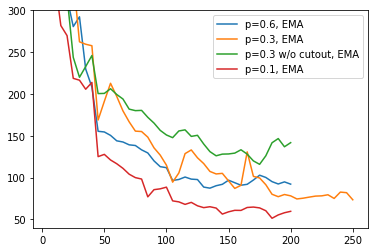

In [25]:
tr2_xs = range(5, 251, 5)
#sns.lineplot(x=tr2_xs[:len(fids_tr2_p06)], y=fids_tr2_p06, label='p=0.6')
sns.lineplot(x=tr2_xs[:len(fids_tr2_p06_ema)], y=fids_tr2_p06_ema, label='p=0.6, EMA')
#sns.lineplot(x=tr2_xs[:len(fids_tr2_p03)], y=fids_tr2_p03, label='p=0.3')
sns.lineplot(x=tr2_xs[:len(fids_tr2_p03_ema)], y=fids_tr2_p03_ema, label='p=0.3, EMA')
#sns.lineplot(x=tr2_xs[:len(fids_tr2_p03_no_co)], y=fids_tr2_p03_no_co, label='p=0.3 w/o cutout')
sns.lineplot(x=tr2_xs[:len(fids_tr2_p03_ema_no_co)], y=fids_tr2_p03_ema_no_co, label='p=0.3 w/o cutout, EMA')
#sns.lineplot(x=tr2_xs[:len(fids_tr2_p01)], y=fids_tr2_p01, label='p=0.1')
ax=sns.lineplot(x=tr2_xs[:len(fids_tr2_p01_ema)], y=fids_tr2_p01_ema, label='p=0.1, EMA')
ax.set_ybound(40, 300)

FID stops going down much earlier than expected, even with low values of `p`. Some transforms might be affecting results negatively, so in next step we'll use ADA together with a smaller set of transforms.

## 3. Train with ADA

Augmentation strength `p` is increased when a given percentage (`preds_above_0_overfit_threshold` param of `AdaptiveAugmentsCallback`) of real preds (logits actually) has a value greather than 0; otherwise, strength is decreased.

In [36]:
def create_learner_3(for_inference=False, p_change_thresh=0.6, filter_tfms_to_array=None,
                     tfms_pad_mode=PadMode.Reflection, dblock=dblock, dls=dls, gp_w=1.):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128, flatten_full=True)
    ada_tfms = ADATransforms(0., (img_size, img_size), pad_mode=tfms_pad_mode)
    tfms_array = (filter_tfms_to_array(ada_tfms) if filter_tfms_to_array is not None
                  else ada_tfms.to_array())
    aug_critic = nn.Sequential(TransformsLayer(setup_aug_tfms(tfms_array)),
                               critic)
    
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    c_loss_interceptors = []
    if not for_inference:
        # Pass critic to avoid grid_sample 2nd order derivative issue with aug_critic
        cbs.append(R1GANGPCallback(weight=gp_w, critic=critic))
        ada_crit_preds_tracker = CritPredsTracker(reduce_batch=False)
        ada_cb = AdaptiveAugmentsCallback(ada_tfms, ada_crit_preds_tracker,
                                          preds_above_0_overfit_threshold=p_change_thresh)
        cbs.append(ada_cb)
        c_loss_interceptors.append(ada_crit_preds_tracker)
        overall_crit_preds_tracker = CritPredsTracker(reduce_batch=True)
        c_loss_interceptors.append(overall_crit_preds_tracker)
        
    def gen_loss_func(*args): return 0
    crit_loss_func = nn.BCEWithLogitsLoss()
    loss_G, loss_C = gan_loss_from_func(gen_loss_func, crit_loss_func)
    loss_C = LossWrapper(loss_C, c_loss_interceptors)
    
    learn = GANLearner(dls, generator, aug_critic, loss_G, loss_C,
                       opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                       cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                       switch_eval=False)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    add_ema_to_gan_learner(learn, dblock, main_path, decay=0.999)
    if not for_inference: learn.crit_preds_tracker = overall_crit_preds_tracker
    return learn


# def discard_color_tfms(tfms):
#     return [tfm for tfm in tfms.to_array() if not isinstance(tfm, (LightingTfm, HSVTfm, RandomErasing))]

def filter_spatial_tfms(ada_tfms):
    return [tfm for tfm in ada_tfms.to_array() if isinstance(tfm, AffineCoordTfm)]

def filter_spatial_minus_rot_small(ada_tfms):
    return [tfm for tfm in ada_tfms.to_array() 
            if (isinstance(tfm, (AffineCoordTfm)) and not isinstance(tfm, Rotate))
                or tfm == ada_tfms.rotate_90x]

def filter_spatial_and_co_minus_rot_small(ada_tfms):
    return [tfm for tfm in ada_tfms.to_array() 
            if (isinstance(tfm, (AffineCoordTfm, RandomErasing)) and not isinstance(tfm, Rotate))
                or tfm == ada_tfms.rotate_90x]

### 3a. Use all transforms

In [37]:
learn = create_learner_3(p_change_thresh=0.9)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime_ada09', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(200, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

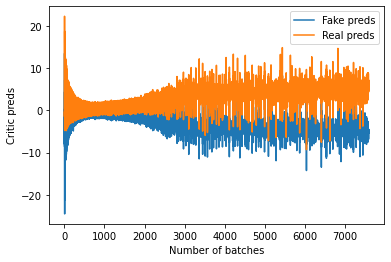

In [40]:
plot_c_preds(learn.crit_preds_tracker)

<AxesSubplot:>

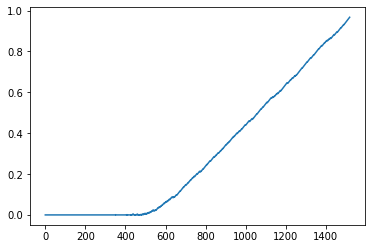

In [35]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('noise2anime_crit_preds_rt09_200ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_rt09_200ep.txt

### 3b. Use only spatial transforms, rotate only 90x

In [50]:
learn = create_learner_3(p_change_thresh=0.6, filter_tfms_to_array=filter_spatial_minus_rot_small)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime_ada06_sp_tfms_no_rot_small', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(360, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

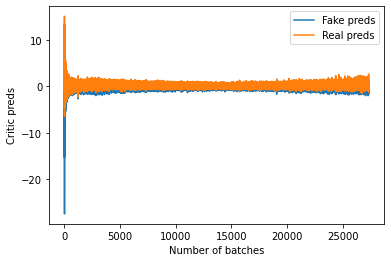

In [14]:
plot_c_preds(learn.crit_preds_tracker)

<AxesSubplot:>

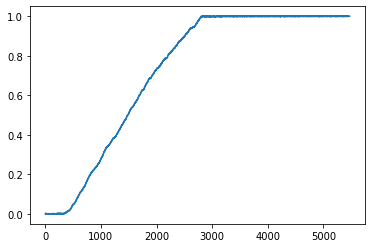

In [15]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('noise2anime_crit_preds_rt06_sp_tfms_no_rot_small_360ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_rt06_sp_tfms_no_rot_small_360ep.txt

### 3c. Use only spatial transforms

In [56]:
learn = create_learner_3(p_change_thresh=0.6, filter_tfms_to_array=filter_spatial_tfms)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime_ada06_spatial_tfms', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(395, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

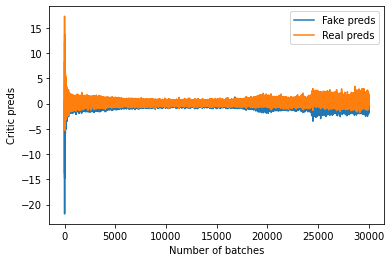

In [58]:
plot_c_preds(learn.crit_preds_tracker)

<AxesSubplot:>

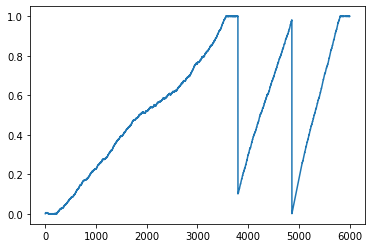

In [60]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

The restarts of `p` to lower values were done manually, and turned out to be effective, as shown in "Evaluation results" section. However, every restart should probably descend less (e.g. first, p=0.; second, p=0.1, and so on).

In [ ]:
save_preds(learn.crit_preds_tracker, Path('noise2anime_crit_preds_rt06_spatial_tfms_395ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_rt06_spatial_tfms_395ep.txt

### 3d. Spatial transforms and Cutout, only Rotate 90x

In [77]:
learn = create_learner_3(p_change_thresh=0.6, filter_tfms_to_array=filter_spatial_and_co_minus_rot_small)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime_ada06_sp_tfms_co_no_rot_small', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(310, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

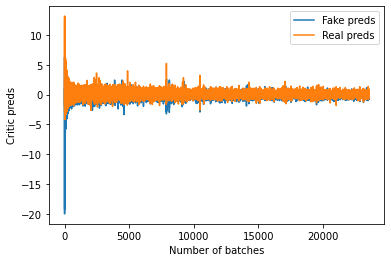

In [20]:
plot_c_preds(learn.crit_preds_tracker)

<AxesSubplot:>

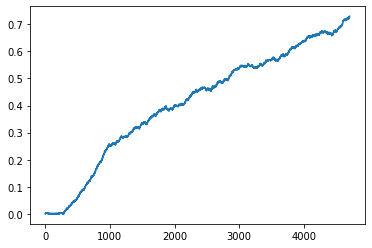

In [16]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('noise2anime_crit_preds_rt06_sp_tfms_co_no_rot_small_310ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_rt06_spatial_tfms_co_no_rot_small_310ep.txt

### 3e. Use only spatial transforms, pad_mode = border

In [82]:
learn = create_learner_3(p_change_thresh=0.6, filter_tfms_to_array=filter_spatial_tfms, 
                         tfms_pad_mode=PadMode.Border)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime_ada06_sp_tfms_padborder', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(250, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

In [ ]:
plot_c_preds(learn.crit_preds_tracker)

In [ ]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('noise2anime_crit_preds_rt06_sp_tfms_padborder_395ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_rt06_sp_tfms_padborder_395ep.txt

### 3f. Use only spatial transforms, pad_mode = zeros

In [83]:
learn = create_learner_3(p_change_thresh=0.6, filter_tfms_to_array=filter_spatial_tfms, 
                         tfms_pad_mode=PadMode.Zeros)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime_ada06_sp_tfms_padzeros', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(270, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

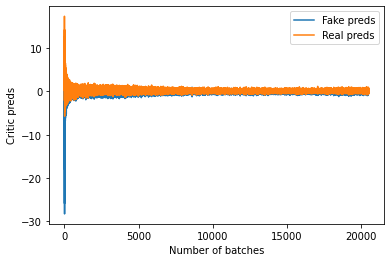

In [85]:
plot_c_preds(learn.crit_preds_tracker)

<AxesSubplot:>

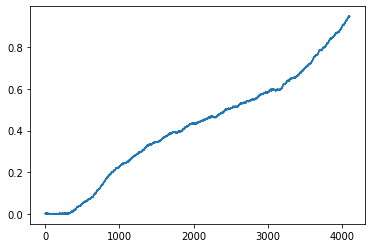

In [87]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('noise2anime_crit_preds_rt06_sp_tfms_padzeros_270ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_rt06_sp_tfms_padzeros_270ep.txt

### 3g. Use only translate and zoom

In [ ]:
def filter_only_translate_zoom(ada_tfms):
    return [ada_tfms.iso_zoom, ada_tfms.int_translation]

In [ ]:
learn = create_learner_3(p_change_thresh=0.6, filter_tfms_to_array=filter_only_translate_zoom)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime_ada06_trans_zoom', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(260, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

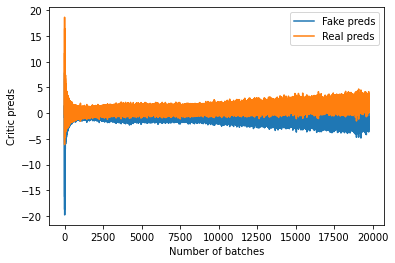

In [21]:
plot_c_preds(learn.crit_preds_tracker)

<AxesSubplot:>

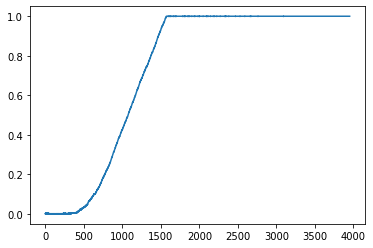

In [22]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

### 3h. Use only pixel blitting

In [ ]:
def filter_only_blitting(ada_tfms):
    return [ada_tfms.flip, ada_tfms.rotate_90x, ada_tfms.int_translation]

In [ ]:
learn = create_learner_3(p_change_thresh=0.6, filter_tfms_to_array=filter_only_blitting)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime_ada06_only_blit', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(240, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

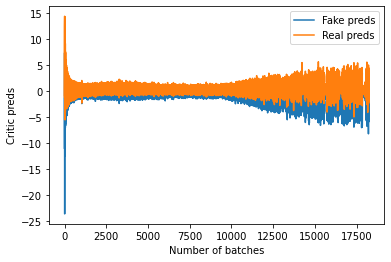

In [23]:
plot_c_preds(learn.crit_preds_tracker)

<AxesSubplot:>

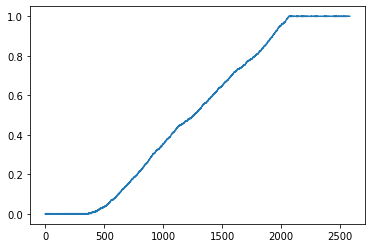

In [24]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

### 3i. Combine best models: use only spatial transforms, rotate only 90x, padding zeros, add flip as ds tfm

In [ ]:
aug_dblock = get_dblock(extra_batch_tfms=[Flip(0.5)])
aug_dls = aug_dblock.dataloaders(main_path, path=main_path, bs=bs)

learn = create_learner_3(p_change_thresh=0.6, filter_tfms_to_array=filter_spatial_minus_rot_small,
                         tfms_pad_mode=PadMode.Zeros, dblock=aug_dblock, dls=aug_dls, gp_w=1.)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime_ada06_sp_tfms_no_rot_small_padzeros_gpw100', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(400, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

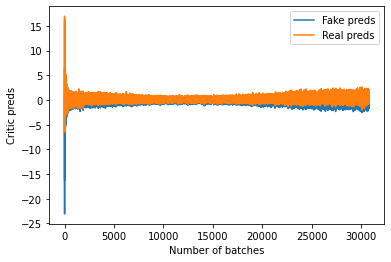

In [25]:
plot_c_preds(learn.crit_preds_tracker)

<AxesSubplot:>

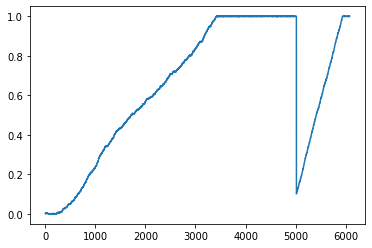

In [26]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('noise2anime_crit_preds_rt06_sp_tfms_no_rot_small_padzeros_400ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_rt06_sp_tfms_no_rot_small_padzeros_400ep.txt

### 3j. Use only spatial transforms, rotate only 90x, add flip as ds tfm and drop it from ada tfms

Keeping flip as an ADA transform while adding it to dataset transforms doesn't make sense at all, it'd be irrelevant, so 3i is wrong and here it's fixed.

In [ ]:
def filter_spatial_minus_flip_rot_small(ada_tfms):
    return [tfm for tfm in ada_tfms.to_array() 
            if (isinstance(tfm, (AffineCoordTfm)) and not isinstance(tfm, (Rotate, Flip)))
                or tfm == ada_tfms.rotate_90x]

In [ ]:
aug_dblock = get_dblock(extra_batch_tfms=[Flip(0.5)])
aug_dls = aug_dblock.dataloaders(main_path, path=main_path, bs=bs)

learn = create_learner_3(p_change_thresh=0.8, filter_tfms_to_array=filter_spatial_minus_flip_rot_small,
                         dblock=aug_dblock, dls=aug_dls)
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime_ada08_sp_tfms_no_rot_small_flip_as_ds', initial_epoch=1,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4

In [ ]:
learn.fit(660, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

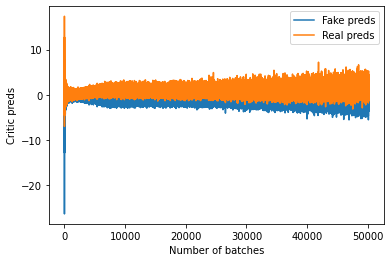

In [27]:
plot_c_preds(learn.crit_preds_tracker)

<AxesSubplot:>

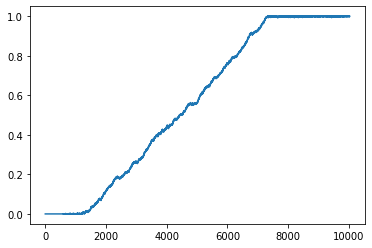

In [28]:
sns.lineplot(x=range(len(learn.adaptive_augments.p_history)), 
             y=learn.adaptive_augments.p_history)

In [ ]:
save_preds(learn.crit_preds_tracker, Path('noise2anime_crit_preds_rt08_sp_tfms_no_rot_small_flip_as_ds_660ep.csv'))
!echo {learn.adaptive_augments.p_history} > p_history_rt08_sp_tfms_no_rot_small_flip_as_ds_660ep.txt

### Evaluation results

In [29]:
fids_tr3 = ([261.6, 203.2, 232.3, 188.4, 174.3, 141.5, 145.2, 138.0, 143.2, 160.6, 134.3, 151.0, 166.6, 147.9, 159.8, 173.3, 161.4, 164.8, 146.2, 170.7]
           + [130.3, 137.3, 148.2, 156.7, 143.4, 142.7, 124.9, 122.1])
fids_tr3_ema = ([355.6, 374.5, 351.9, 324.3, 280.6, 283.9, 260.9, 233.9, 130.0, 124.9, 134.1, 179.5, 208.8, 218.1, 250.4, 305.4, 242.9, 300.1, 231.2, 211.1]
                + [200.4, 181.5, 168.0, 165.0])
# It reached p=1 after epoch 80 approximately and then it stays constant, degrading performance, so no need to go on training.
fids_tr3_rt08 = ([220.7, 169.4, 141.2, 120.0, 99.5, 106.1, 91.8, 113.9, 109.7, 109.7, 95.1, 120.1, 100.6, 114.0, 107.4, 101.7, 104.2, 119.8, 110.8, 125.8] 
                 + [112.1, 106.9, 140.3, 96.1, 142.9, 123.7, 114.1, 131.7, 106.2, 118.9])
fids_tr3_rt08_ema = ([393.4, 306.8, 244.2, 219.6, 270.7, 288.5, 290.8, 312.3, 88.6, 91.9, 91.2, 104.7, 97.6, 130.4, 149.8, 148.4, 147.5, 159.3, 162.9, 153.2] 
                     + [138.9, 135.6, 90.9, 93.8, 94.9, 97.4, 105.6, 114.0, 113.0, 110.7])
fids_tr3_rt09 = [225.2, 160.6, 130.5, 108.1, 101.8, 88.2, 83.4, 70.6, 81.1, 70.3, 85.1, 77.0, 92.9, 86.3, 92.8, 91.5, 97.2, 119.4, 125.0, 143.1]
fids_tr3_rt09_ema = [341.4, 331.5, 266.6, 203.6, 268.2, 323.8, 261.2, 287.5, 305.5, 270.7, 220.6, 227.3, 62.9, 67.2, 66.6, 73.6, 77.1, 85.1, 92.1, 97.2]
fids_tr3_rt095 = [207.2, 171.4, 130.1, 113.2, 93.7, 79.8, 64.7, 68.2, 73.6, 75.1, 78.3, 77.0, 73.8, 97.7, 78.8, 85.7, 102.5, 92.4, 88.6, 115.1]
fids_tr3_rt095_ema = [326.3, 297.4, 211.5, 216.1, 264.0, 275.5, 290.5, 303.6, 60.9, 57.7, 55.1, 58.3, 64.4, 71.3, 88.6, 91.5, 70.7, 101.8, 99.1, 89.5]
fids_tr3_rt08_sp_tfms_no_rot_small = ([226.5, 158.3, 109.0, 96.2, 74.1, 58.9, 51.0, 50.0, 45.9, 39.6, 37.5, 38.0, 36.9, 35.4, 37.4, 31.5, 28.4, 26.6, 31.7, 31.8]
                                     + [25.0, 26.9, 25.0, 26.5, 22.9, 24.0, 21.8, 21.6, 22.8, 21.0, 21.3, 21.0, 20.6, 21.3, 22.0, 19.9, 21.4, 20.5, 22.3, 21.1]
                                     + [21.7, 20.0, 23.1, 22.9, 20.2, 19.5, 18.9, 24.9, 22.1, 23.4])
# With p restart to 0 (251-?): [22.0, 23.3, 23.0, 20.7, 20.5, 26.7, 20.3]
fids_tr3_rt08_sp_tfms_no_rot_small_ema = ([314.4, 311.9, 254.1, 247.8, 126.0, 112.6, 99.5, 78.2, 41.7, 38.5, 34.6, 32.2, 29.7, 28.0, 26.6, 25.9, 23.7, 22.9, 22.1, 21.4]
                                         + [20.3, 19.7, 19.4, 19.2, 17.8, 17.7, 17.4, 17.4, 16.7, 16.5, 16.2, 16.2, 15.6, 15.7, 15.7, 15.6, 15.7, 15.5, 15.5, 15.0]
                                         + [14.9, 15.1, 15.1, 15.1, 14.8, 15.0, 14.8, 15.3, 15.4, 15.3])
# With p restart to 0 (251-?): [15.5, 16.0, 16.0, 15.7, 15.5, 15.7, 15.5]
fids_tr3_rt06_sp_tfms_no_rot_small = ([240.9, 166.0, 130.7, 94.6, 78.3, 64.2, 68.3, 43.7, 45.9, 41.8, 32.4, 36.0, 33.6, 30.1, 27.7, 27.7, 25.5, 27.4, 20.9, 24.2]
                                      + [23.1, 24.9, 25.2, 24.8, 21.4, 22.9, 22.8, 22.9, 23.2, 18.0, 18.6, 22.4, 21.0, 22.1, 21.8, 24.7, 19.5, 19.5, 19.8, 18.8]
                                      + [17.9, 25.1, 19.4, 18.3, 18.0, 22.5, 20.2, 21.8, 19.3, 22.2, 17.7, 22.0, 20.3, 18.5, 16.8, 18.9, 18.8, 21.5, 19.1, 28.6]
                                      + [18.6, 17.1, 17.4, 16.9, 20.9, 21.6, 17.8, 18.5, 16.9, 19.3, 18.2, 22.4])
fids_tr3_rt06_sp_tfms_no_rot_small_ema = ([341.6, 347.1, 234.9, 201.3, 134.1, 97.4, 72.0, 56.1, 39.1, 35.4, 33.6, 31.5, 26.3, 25.4, 24.9, 23.9, 21.1, 21.0, 20.9, 20.7]
                                          + [19.5, 19.3, 19.0, 18.7, 18.5, 17.9, 17.6, 17.2, 16.2, 16.1, 15.8, 16.8, 16.1, 16.2, 15.5, 15.8, 15.7, 16.1, 15.3, 15.5]
                                          + [15.0, 15.3, 15.2, 15.3, 15.1, 15.6, 15.1, 15.3, 14.5, 14.6, 14.4, 14.8, 14.7, 15.0, 14.4, 14.6, 14.4, 14.1, 13.9, 13.9]
                                          + [13.5, 13.8, 13.5, 13.8, 13.7, 14.0, 13.6, 13.9, 13.5, 13.9, 13.7, 13.7])
# Epoch 250-290, after a while of p=1, have a lot of artifacts and noise, despite the lower FID
# These include 10 additional epochs of normal training not included before the first restart, 
# so fids_tr3_rt06_spatial_tfms_after_r1 starts with an FID of 22.0, not 20.3
fids_tr3_rt06_spatial_tfms = ([224.6, 160.0, 109.5, 84.8, 64.8, 56.8, 55.1, 38.6, 33.7, 32.1, 37.9, 29.9, 28.4, 23.4, 23.4, 26.7, 29.5, 25.7, 23.8, 28.6]
                             + [24.9, 21.9, 23.1, 21.5, 23.5, 21.6, 22.5, 24.5, 23.1, 20.5, 22.3, 21.5, 22.5, 27.8, 21.2, 21.5, 22.8, 21.9, 20.5, 19.2]
                             + [21.4, 18.7, 19.8, 21.5, 21.3, 24.8, 25.1, 21.1, 22.0, 22.0, 20.5, 20.3])
# With restart to p=0.1 ep 251-320: 
fids_tr3_rt06_spatial_tfms_after_r1 = [22.0, 18.7, 21.8, 17.1, 19.7, 22.7, 17.3, 19.1, 21.9, 18.2, 17.2, 19.5, 16.6, 19.7]
# With restart to p=0, ep 321-395: 
fids_tr3_rt06_spatial_tfms_after_r2 = [25.6, 20.3, 18.8, 20.2, 21.5, 17.4, 16.8, 21.0, 17.3, 17.1, 17.5, 20.3, 20.2, 18.4, 20.2]
fids_tr3_rt06_spatial_tfms_ema = ([312.1, 338.6, 288.3, 255.4, 143.6, 117.6, 85.8, 60.2, 37.0, 34.4, 32.4, 30.8, 25.5, 24.9, 23.5, 22.5, 20.8, 20.6, 20.1, 20.2]
                                 + [19.1, 18.3, 18.6, 18.6, 18.5, 18.4, 18.3, 18.5, 17.8, 17.4, 17.5, 17.1, 16.6, 16.4, 16.7, 16.6, 16.1, 16.3, 16.5, 16.5]
                                 + [15.7, 15.9, 15.8, 15.9, 15.7, 16.2, 16.2, 16.2, 16.4, 16.3, 16.4, 16.2])
# With restart to p=0.1 ep 251-320: 
fids_tr3_rt06_spatial_tfms_ema_after_r1 = [16.3, 15.9, 15.6, 15.2, 14.8, 14.2, 14.2, 14.3, 14.0, 13.8, 13.8, 13.6, 13.6, 13.7]
# Recalculated after BN update:     [?, ..., 13.5, ?, ?, ?, 13.5]
#                                          (350)
# With restart to p=0, ep 321-395: 
fids_tr3_rt06_spatial_tfms_ema_after_r2 = [14.2, 14.9, 14.7, 14.5, 14.1, 13.7, 13.2, 13.4, 13.1, 13.1, 13.2, 13.3, 13.3, 13.8, 13.7]
# Recalculated after BN update:   [?, ..., 13.5, ?, ?, ?, 12.9, ?, 13.1, 13.2, ?, ?]
fids_tr3_rt06_sp_tfms_co_no_rot_small = ([213.0, 141.8, 105.8, 83.5, 77.5, 62.4, 52.1, 44.2, 46.7, 41.0, 39.1, 35.4, 37.2, 28.4, 32.9, 33.3, 29.5, 31.8, 32.6, 26.9]
                                        + [29.4, 26.5, 24.2, 29.5, 24.1, 28.7, 25.4, 33.1, 26.1, 29.4, 22.4, 26.0, 23.8, 23.5, 30.1, 23.4, 20.9, 23.4, 27.7, 22.1]
                                        + [23.4, 21.4, 21.7, 21.0, 21.0, 20.9, 22.0, 24.0, 22.4, 20.8, 24.4, 30.0, 22.8, 21.6, 19.6, 25.2, 20.6, 21.3, 20.8, 20.8]
                                        + [21.4, 28.2, 19.8, 20.2])
fids_tr3_rt06_sp_tfms_co_no_rot_small_ema = ([399.4, 326.5, 277.7, 272.0, 122.6, 96.0, 77.0, 64.0, 42.1, 38.9, 37.1, 34.8, 29.6, 29.2, 26.9, 26.3, 24.7, 24.7, 23.0, 22.8]
                                            + [23.3, 22.8, 20.1, 20.3, 19.6, 19.7, 19.4, 19.5, 18.7, 18.9, 17.9, 17.3, 17.1, 17.4, 17.2, 16.9, 16.5, 16.5, 16.3, 16.9]
                                            + [16.3, 16.2, 16.0, 15.9, 15.9, 15.8, 15.7, 16.0, 15.9, 15.8, 16.2, 16.1, 15.6, 15.3, 15.2, 15.2, 15.1, 15.4, 15.7, 15.9]
                                            + [15.5, 15.7, 15.3, 15.3])
# Recalculated after BN update: {'40ep': 45.2, '70ep', 27.0, '100ep': 21.8, '140ep': 18.7}
fids_tr3_rt06_spatial_tfms_padborder = ([219.7, 179.6, 127.9, 94.8, 74.4, 54.0, 52.5, 49.2, 46.8, 35.6, 51.2, 30.8, 33.0, 28.6, 26.9, 28.6, 25.8, 26.6, 27.4, 25.4]
                                       + [21.1, 29.5, 22.4, 22.4, 23.3, 22.8, 27.8, 24.6, 21.7, 19.9, 23.1, 21.4, 21.2, 19.8, 20.9, 20.6, 20.7, 21.5, 22.4, 23.9]
                                       + [19.9, 21.7, 22.4, 20.9, 23.4, 21.7, 21.7, 22.5, 25.5, 23.3])
fids_tr3_rt06_spatial_tfms_padborder_ema = ([331.8, 310.5, 237.7, 203.8, 130.5, 100.1, 77.9, 61.9, 38.7, 34.6, 31.7, 29.8, 26.8, 25.8, 24.9, 24.3, 22.5, 21.9, 21.2, 21.0]
                                           + [20.5, 20.2, 20.0, 19.7, 19.1, 19.2, 19.3, 18.9, 18.7, 18.6, 18.0, 17.7, 17.4, 17.1, 17.2, 17.0, 17.0, 17.1, 17.5, 17.2]
                                           + [16.7, 16.3, 16.5, 16.6, 16.5, 17.1, 17.1, 17.2, 16.7, 17.1])
fids_tr3_rt06_spatial_tfms_padzeros = ([214.8, 151.6, 106.5, 74.6, 74.5, 52.1, 52.7, 45.7, 41.3, 38.7, 35.6, 34.5, 36.1, 27.9, 27.2, 26.3, 27.3, 29.1, 24.2, 25.9]
                                      + [23.8, 28.4, 26.8, 25.9, 24.9, 23.7, 23.5, 22.8, 21.9, 19.4, 20.0, 22.6, 21.0, 20.7, 21.6, 21.0, 21.5, 25.0, 19.2, 19.5]
                                      + [19.0, 23.3, 22.0, 22.2, 18.7, 17.8, 19.2, 20.3, 20.5, 22.5, 19.5, 22.5, 23.2, 22.7])
fids_tr3_rt06_spatial_tfms_padzeros_ema = ([345.9, 336.1, 269.9, 222.2, 144.6, 120.7, 91.5, 65.7, 39.7, 36.3, 33.9, 32.5, 28.0, 27.2, 26.5, 25.7, 23.1, 22.9, 23.2, 22.2]
                                          + [20.7, 20.8, 20.0, 19.6, 19.1, 18.9, 18.6, 18.3, 17.6, 17.5, 17.3, 18.1, 23.4, 22.4, 24.0, 22.5, 15.9, 15.7, 17.8, 30.3]
                                          + [34.4, 31.0, 16.3, 16.5, 16.3, 15.8, 15.4, 15.2, 15.2, 15.0, 15.2, 15.0, 15.1, 15.1])
fids_tr3_rt06_zoom_inttrans = ([210.1, 169.2, 122.6, 98.1, 71.5, 62.0, 57.0, 50.1, 41.9, 38.6, 39.4, 35.6, 32.5, 32.8, 34.1, 28.7, 30.6, 25.8, 26.7, 27.8]
                              + [29.3, 23.4, 25.8, 22.6, 22.8, 28.6, 21.7, 20.6, 22.5, 21.5, 21.8, 22.9, 22.0, 22.2, 23.7, 22.9, 23.2, 22.1, 19.3, 21.8]
                              + [21.3, 18.9, 20.6, 21.1, 23.0, 22.1, 22.0, 21.5, 21.5, 21.1, 23.4, 22.8])
fids_tr3_rt06_zoom_inttrans_ema = ([343.6, 298.1, 227.7, 259.7, 138.5, 112.2, 87.9, 67.8, 42.7, 38.2, 35.4, 33.2, 28.6, 27.3, 26.0, 25.1, 23.8, 22.6, 21.7, 20.7]
                                  + [19.0, 18.7, 18.2, 18.2, 17.3, 17.5, 17.3, 17.3, 16.6, 16.9, 16.6, 16.5, 16.9, 16.8, 16.5, 16.1, 16.5, 16.5, 16.0, 15.9]
                                  + [16.0, 15.6, 15.7, 15.9, 15.7, 15.8, 15.6, 15.7, 16.0, 15.7, 15.6, 15.6])
fids_tr3_rt06_sp_tfms_no_rot_small_padzeros = ([217.4, 161.8, 103.8, 85.3, 67.5, 52.4, 46.1, 38.2, 39.3, 38.2, 34.6, 32.7, 31.4, 25.4, 28.0, 24.2, 27.3, 27.6, 23.2, 23.0]
                                               + [26.8, 21.8, 25.7, 23.2, 24.5, 20.8, 21.9, 24.5, 20.1, 23.4, 20.1, 19.9, 23.0, 22.3, 19.5, 18.3, 23.1, 18.9, 22.9, 21.9]
                                               + [20.4, 22.2, 22.4, 25.6, 21.6, 23.2, 22.9, 21.9, 22.7, 21.7, 19.8, 20.9, 20.2, 18.9, 21.8, 17.0, 20.6, 19.3, 18.2, 18.2]
                                               + [18.4, 18.9, 21.2, 18.1, 18.5, 19.2])
fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_after_r1 = [18.8, 18.3, 19.9, 19.3, 16.2, 17.0, 17.5, 20.1, 15.5, 17.1, 16.7, 18.6]
fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_ema = ([312.6, 315.4, 287.1, 202.9, 122.3, 95.7, 77.7, 65.7, 48.0, 40.9, 34.6, 31.3, 26.6, 25.5, 24.1, 23.2, 21.5, 21.4, 20.3, 19.3]
                                                   + [18.4, 18.1, 17.9, 17.7, 17.0, 16.7, 16.9, 16.7, 16.7, 16.4, 16.5, 16.3, 16.1, 16.0, 15.9, 16.1, 15.7, 15.6, 15.1, 15.1]
                                                   + [15.0, 14.9, 15.2, 15.4, 15.5, 15.5, 15.3, 15.2, 15.1, 15.4, 15.4, 14.8, 15.0, 14.6, 14.6, 14.3, 14.2, 14.1, 13.8, 13.7]
                                                   + [13.4, 13.6, 13.7, 13.7, 13.6, 13.9])
fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_ema_after_r1 = [13.5, 13.6, 13.7, 13.9, 13.6, 13.2, 12.9, 12.7, 12.4, 12.5, 12.5, 12.8]
fids_tr3_rt06_only_blit = ([205.9, 143.8, 113.4, 82.4, 63.3, 60.2, 52.3, 40.9, 43.8, 38.1, 33.6, 35.2, 31.9, 28.1, 31.9, 26.4, 23.1, 24.8, 24.0, 21.0]
                           + [22.5, 27.0, 24.2, 23.9, 24.7, 25.5, 26.4, 24.7, 23.1, 23.7, 24.4, 26.3, 25.1, 27.6])
fids_tr3_rt06_only_blit_after_r1_fixed07 = [24.4, 19.6, 22.3, 23.8, 24.1, 21.5, 22.5, 31.5, 23.2, 23.1]
fids_tr3_rt06_only_blit_ema = ([355.3, 319.6, 263.5, 247.8, 120.8, 91.1, 72.7, 59.2, 37.7, 33.9, 31.7, 29.5, 25.3, 24.1, 23.3, 22.5, 20.0, 19.6, 18.6, 18.7]
                              + [17.5, 17.8, 17.3, 17.1, 17.7, 17.7, 17.2, 17.3, 17.3, 17.3, 17.0, 17.3, 17.3, 17.5])
fids_tr3_rt06_only_blit_ema_after_r1_fixed07 = [17.1, 16.9, 17.2, 17.3, 16.6, 16.7, 16.1, 16.3, 16.3, 16.6]
fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw01 = ([216.7, 153.4, 107.9, 89.0, 71.8, 54.0, 47.8, 39.3, 43.5, 38.8, 33.3, 31.3, 28.7, 33.0, 32.2, 31.6, 29.0, 33.7, 35.7, 35.5]
                                                    + [35.3, 28.8, 30.1, 27.4, 32.2, 34.5, 32.3, 26.7, 28.3, 25.8, 29.0, 32.1])
fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw01_ema = ([346.1, 354.0, 321.0, 215.1, 124.4, 89.2, 68.4, 55.8, 40.6, 37.8, 34.7, 31.7, 28.1, 26.5, 25.6, 24.8, 23.7, 23.4, 22.5, 21.9]
                                                        + [21.7, 22.2, 22.2, 22.1, 21.5, 21.3, 21.6, 21.6, 21.3, 21.0, 21.3, 20.7])
fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw10 = ([228.4, 177.0, 110.6, 91.1, 73.8, 58.6, 48.8, 46.1, 48.1, 36.2, 39.2, 39.8, 33.5, 33.4, 33.6, 33.9, 28.6, 32.3, 31.1, 25.7]
                                                    + [29.6, 23.5, 27.3, 27.1, 27.5, 27.6, 26.2, 22.8, 22.8, 26.7, 29.4, 23.3, 24.7, 21.6, 20.4, 20.2, 22.9, 21.1, 23.2, 21.7]
                                                    + [22.8, 23.2, 19.9, 22.2, 21.1, 22.7, 18.5, 18.2, 19.4, 18.0, 20.6, 21.3, 21.5, 19.9, 18.8, 21.7, 20.6, 19.3, 21.5, 20.4]
                                                    + [21.2, 21.7, 19.2, 24.0, 18.3, 18.1, 18.7, 22.9, 18.6, 22.0, 20.4, 17.7, 18.4, 22.6, 20.2, 20.4, 21.4, 17.8, 21.0, 17.8]
                                                    + [19.9, 20.0, 19.3, 22.4, 18.4, 17.8, 23.0, 16.8])
fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw10_ema = ([322.1, 359.7, 313.5, 233.1, 141.0, 102.9, 76.6, 60.6, 42.5, 39.0, 39.9, 38.2, 29.2, 26.9, 25.9, 24.9, 23.4, 22.7, 22.1, 21.6]
                                                        + [20.7, 20.4, 18.9, 18.7, 18.6, 18.3, 17.6, 17.8, 17.6, 17.5, 17.2, 16.9, 16.5, 16.7, 16.7, 16.6, 15.9, 16.3, 16.3, 15.8]
                                                        + [15.9, 15.9, 15.7, 15.7, 15.5, 15.5, 15.2, 14.8, 14.5, 14.9, 14.8, 14.7, 14.7, 14.6, 14.4, 14.3, 14.0, 14.2, 14.5, 14.6]
                                                        + [14.7, 14.7, 14.6, 14.7, 14.3, 14.4, 14.1, 14.1, 14.4, 14.1, 14.0, 14.1, 13.9, 14.0, 13.8, 13.7, 13.7, 13.7, 13.8, 13.7]
                                                        + [13.6, 13.7, 13.7, 13.5, 13.6, 13.9, 14.1, 14.4])
fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw100 = ([296.4, 236.6, 220.4, 200.5, 160.3, 128.5, 116.7, 100.3, 84.2, 69.1, 67.1, 65.8, 52.3, 56.1, 51.3, 45.6, 43.2, 45.2, 47.1, 34.7]
                                                     + [33.4, 43.8, 35.5, 38.3, 33.1, 31.4, 33.1, 30.2, 32.2, 30.6, 29.8, 33.7, 29.7, 33.4, 27.7, 29.2, 33.5, 26.9, 35.5, 31.6]
                                                     + [30.6, 28.6, 32.0, 29.6, 30.4, 29.0, 26.7, 25.8, 27.7, 31.8, 29.5, 34.7, 30.4, 30.5, 25.5, 23.9, 26.0, 28.1, 26.5, 27.7]
                                                     + [28.2, 30.3, 24.5, 24.4, 24.3, 20.4, 25.0, 27.4, 25.2, 23.1, 28.6, 26.5, 24.8, 26.4, 24.5, 23.9])
fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw100_ema = ([358.3, 348.4, 252.9, 251.5, 220.6, 189.7, 164.7, 140.9, 107.3, 89.2, 74.9, 65.1, 50.7, 48.3, 44.1, 40.7, 35.8, 33.5, 32.3, 30.8]
                                                         + [28.2, 27.6, 26.6, 26.2, 26.2, 25.8, 25.7, 25.3, 23.6, 23.6, 23.6, 23.7, 22.3, 22.1, 22.1, 22.3, 20.7, 21.2, 21.0, 21.3]
                                                         + [21.0, 21.2, 21.2, 20.8, 19.8, 20.2, 20.4, 20.8, 20.0, 20.1, 19.7, 20.0, 19.4, 19.5, 18.9, 19.1, 18.8, 18.9, 18.5, 18.8]
                                                         + [18.5, 18.6, 18.8, 18.7, 18.5, 18.2, 18.3, 18.4, 18.4, 18.5, 18.9, 18.6, 18.0, 18.0, 18.0, 18.2])
fids_tr3_rt06_sp_tfms_no_rot_small_flip_as_ds = ([231.1, 173.5, 115.4, 91.5, 74.7, 59.8, 55.1, 46.8, 45.5, 35.8, 32.8, 29.4, 30.9, 28.2, 29.2, 23.4, 24.9, 24.5, 27.4, 21.3]
                                                + [25.2, 19.3, 23.8, 23.2, 24.3, 21.5, 22.4, 22.1, 20.5, 19.2, 20.7, 20.2, 21.9, 20.7, 20.8, 19.7, 20.8, 19.6, 22.5, 19.2]
                                                + [21.3, 17.2, 19.3, 17.0])
fids_tr3_rt06_sp_tfms_no_rot_small_flip_as_ds_ema = ([418.3, 340.4, 312.9, 285.3, 133.5, 101.8, 65.5, 53.8, 39.1, 34.6, 29.8, 28.8, 26.2, 25.1, 23.6, 22.8, 22.0, 20.8, 19.5, 19.2]
                                                    + [18.8, 18.0, 17.1, 16.9, 17.0, 16.5, 15.9, 16.2, 16.0, 15.7, 15.7, 16.0, 15.8, 15.6, 15.6, 15.4, 15.0, 15.2, 15.1, 15.0]
                                                    + [14.2, 14.1, 14.3, 14.4])
fids_tr3_rt08_sp_tfms_no_rot_small_flip_as_ds = ([216.3, 173.0, 122.3, 87.6, 74.2, 70.3, 52.1, 51.4, 43.6, 36.0, 38.0, 43.5, 29.3, 33.1, 33.3, 30.8, 31.1, 32.9, 28.4, 25.8]
                                                + [23.1, 24.8, 25.6, 25.6, 23.9, 25.4, 24.1, 24.7, 22.9, 22.2, 24.4, 17.9, 21.4, 20.8, 19.8, 21.3, 18.7, 20.5, 21.2, 18.7]
                                                + [18.5, 18.1, 19.7, 17.8, 17.3, 19.5, 19.7, 19.3, 16.5, 17.5, 20.2, 18.1, 15.8, 18.2, 16.9, 19.8, 16.4, 17.5, 16.0, 17.9]
                                                + [20.0, 19.1, 17.9, 16.7, 17.6, 16.9, 18.9, 16.9, 19.4, 18.3, 17.9, 18.2, 18.3, 18.1, 15.8, 19.2, 21.4, 17.7, 17.5, 19.2]
                                                + [17.1, 20.4, 17.8, 19.8, 15.5, 16.7, 19.9, 17.4, 16.1, 15.9, 17.7, 16.9, 18.7, 18.0, 15.4, 21.9, 17.0, 19.7, 18.5, 16.9]
                                                + [17.7, 17.4, 15.7, 18.1, 16.4, 17.0, 18.7, 17.7, 17.2, 18.4, 17.7, 17.6, 17.3, 17.9, 17.2, 16.5, 16.7, 15.9, 17.9, 18.6]
                                                + [18.6, 19.7, 15.8, 17.9, 14.7, 17.0, 17.4, 14.9, 20.5, 19.4, 17.8, 16.5])
fids_tr3_rt08_sp_tfms_no_rot_small_flip_as_ds_ema = ([341.2, 282.6, 227.1, 280.8, 197.6, 233.8, 162.2, 87.5, 39.6, 36.1, 34.8, 32.8, 28.5, 28.0, 27.3, 26.5, 26.0, 25.0, 24.4, 23.0]
                                                    + [20.9, 20.5, 20.0, 19.3, 18.2, 17.9, 18.0, 17.5, 17.4, 17.0, 16.6, 16.3, 15.4, 15.6, 15.4, 15.3, 14.4, 14.9, 14.4, 14.2]
                                                    + [14.2, 14.1, 14.4, 14.5, 13.7, 14.2, 13.8, 13.8, 13.5, 13.5, 13.3, 13.4, 13.1, 13.1, 13.0, 13.2, 12.7, 12.8, 12.7, 13.1]
                                                    + [13.0, 13.1, 13.2, 13.4, 12.9, 13.0, 12.6, 12.8, 12.9, 13.0, 12.9, 12.9, 12.8, 12.9, 12.5, 12.9, 12.7, 13.0, 13.0, 12.8]
                                                    + [12.9, 13.2, 12.8, 12.9, 12.6, 12.7, 12.1, 12.3, 12.1, 12.5, 12.9, 13.3, 12.8, 12.9, 11.8, 11.9, 11.9, 11.8, 11.6, 11.8]
                                                    + [11.8, 11.8, 11.6, 11.6, 11.7, 11.8, 11.7, 11.7, 11.4, 11.7, 11.9, 12.0, 11.5, 11.9, 12.8, 12.6, 11.7, 12.3, 13.3, 13.3]
                                                    + [12.2, 12.4, 12.0, 12.2, 12.2, 12.4, 12.2, 12.4, 11.9, 11.8, 12.0, 11.9])
fids_tr3_rt05_sp_tfms_no_rot_small_flip_as_ds = ([225.4, 167.6, 120.0, 86.5, 63.5, 58.5, 49.6, 38.9, 38.0, 40.4, 40.6, 34.1, 39.2, 33.2, 28.0, 41.8, 33.1, 30.0, 28.1, 27.8]
                                                + [31.5, 25.2, 26.6, 26.2, 27.2, 23.6, 24.9, 24.2])
fids_tr3_rt05_sp_tfms_no_rot_small_flip_as_ds_ema = ([381.4, 308.2, 294.2, 247.2, 138.8, 109.9, 84.9, 65.5, 40.1, 36.8, 33.8, 32.5, 28.8, 26.9, 26.1, 24.7, 24.0, 23.4, 23.2, 22.7]
                                                    + [22.0, 21.0, 20.5, 20.5, 19.6, 19.2, 19.1, 18.8])

In [41]:
def plot_fids_vs_epochs(fids_list, **lineplot_kwargs):
    x = range(save_cycle_len, save_cycle_len * len(fids_list) + 1, save_cycle_len)
    y = fids_list
    ax = sns.lineplot(x=x, y=y, **lineplot_kwargs)
    ax.set_xlabel('Number of epochs')
    ax.set_ylabel('FID')
    return ax

In [30]:
# DELETE MEEEEE after testing everythinh with plot_fids_vs_epochs
def get_x_y_for_plot(fids_list):
    x = range(save_cycle_len, save_cycle_len * len(fids_list) + 1, save_cycle_len)
    y = fids_list
    return dict(x=x, y=y)

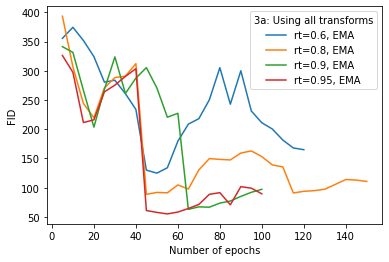

In [43]:
#plot_fids_vs_epochs(fids_tr3, label='rt=0.6')
plot_fids_vs_epochs(fids_tr3_ema, label='rt=0.6, EMA')
#plot_fids_vs_epochs(fids_tr3_rt08, label='rt=0.8')
plot_fids_vs_epochs(fids_tr3_rt08_ema, label='rt=0.8, EMA')
#plot_fids_vs_epochs(fids_tr3_rt09, label='rt=0.9')
plot_fids_vs_epochs(fids_tr3_rt09_ema, label='rt=0.9, EMA')
#plot_fids_vs_epochs(fids_tr3_rt095, label='rt=0.95')
plot_fids_vs_epochs(fids_tr3_rt095_ema, label='rt=0.95, EMA')
plt.legend(title='3a: Using all transforms')

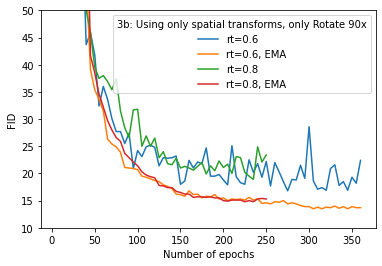

In [44]:
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small, label='rt=0.6')
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_ema, label='rt=0.6, EMA')
plot_fids_vs_epochs(fids_tr3_rt08_sp_tfms_no_rot_small, label='rt=0.8')
ax=plot_fids_vs_epochs(fids_tr3_rt08_sp_tfms_no_rot_small_ema, label='rt=0.8, EMA')
ax.set_ybound(10, 50)
plt.legend(title='3b: Using only spatial transforms, only Rotate 90x')

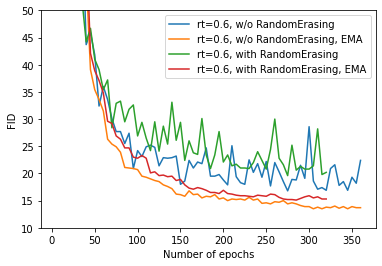

In [46]:
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small, 
                    label='rt=0.6, w/o RandomErasing')
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_ema,
                    label='rt=0.6, w/o RandomErasing, EMA')
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_co_no_rot_small, 
                    label='rt=0.6, with RandomErasing')
ax=plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_co_no_rot_small_ema, 
                       label='rt=0.6, with RandomErasing, EMA')
ax.set_ybound(10, 50)

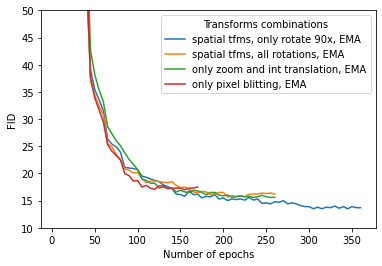

In [47]:
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_ema, 
                    label='spatial tfms, only rotate 90x, EMA')
plot_fids_vs_epochs(fids_tr3_rt06_spatial_tfms_ema, 
                    label='spatial tfms, all rotations, EMA')
plot_fids_vs_epochs(fids_tr3_rt06_zoom_inttrans_ema, 
                    label='only zoom and int translation, EMA')
ax=plot_fids_vs_epochs(fids_tr3_rt06_only_blit_ema, 
                       label='only pixel blitting, EMA')
ax.set_ybound(10, 50)
plt.legend(title='Transforms combinations')

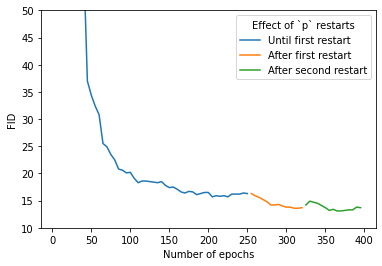

In [48]:
plot_fids_vs_epochs(fids_tr3_rt06_spatial_tfms_ema[:50], label='Until first restart')
sns.lineplot(x=range(255, 321, 5), y=fids_tr3_rt06_spatial_tfms_ema_after_r1, 
             label='After first restart')
ax=sns.lineplot(x=range(325, 396, 5), y=fids_tr3_rt06_spatial_tfms_ema_after_r2, 
                label='After second restart')
ax.set_ybound(10, 50)
plt.legend(title='Effect of `p` restarts')

This could very well be a sign that `rt` is too restrictive (too low) and, as a consequence, p grows too quickly. Anyway, every restart should probably descend less (e.g. first, p=0.; second, p=0.1, and so on)

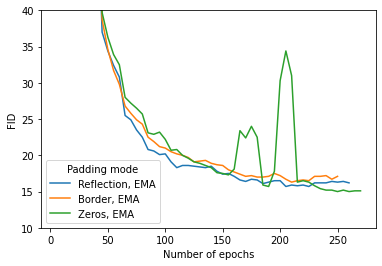

In [50]:
#plot_fids_vs_epochs(fids_tr3_rt06_spatial_tfms, label='Reflection')
plot_fids_vs_epochs(fids_tr3_rt06_spatial_tfms_ema, label='Reflection, EMA')
#plot_fids_vs_epochs(fids_tr3_rt06_spatial_tfms_padborder, label='Border')
plot_fids_vs_epochs(fids_tr3_rt06_spatial_tfms_padborder_ema, label='Border, EMA')
#plot_fids_vs_epochs(fids_tr3_rt06_spatial_tfms_padzeros, label='Zeros')
ax=plot_fids_vs_epochs(fids_tr3_rt06_spatial_tfms_padzeros_ema, label='Zeros, EMA')
ax.set_ybound(10, 40)
plt.legend(title='Padding mode')

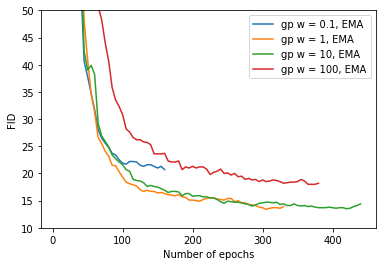

In [52]:
# plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw01,
#                     label='gp w = 0.1')
# plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_padzeros,
#                     label='gp w = 1')
# plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw10,
#                     label='gp w = 10')
# plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw100,
#                     label='gp w = 100')
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw01_ema,
                    label='gp w = 0.1, EMA')
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_ema,
                    label='gp w = 1, EMA')
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw10_ema,
                    label='gp w = 10, EMA')
ax=plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_padzeros_gpw100_ema,
                       label='gp w = 100, EMA')
ax.set_ybound(10, 50)

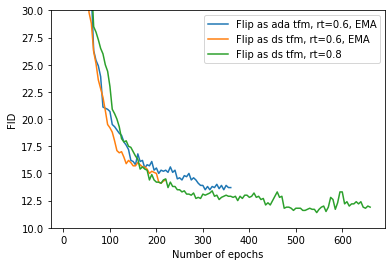

In [53]:
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_ema, 
                    label='Flip as ada tfm, rt=0.6, EMA')
plot_fids_vs_epochs(fids_tr3_rt06_sp_tfms_no_rot_small_flip_as_ds_ema,
                    label='Flip as ds tfm, rt=0.6, EMA')
ax=plot_fids_vs_epochs(fids_tr3_rt08_sp_tfms_no_rot_small_flip_as_ds_ema, 
                       label='Flip as ds tfm, rt=0.8')
ax.set_ybound(10, 30)

As expected, it's better to use x-flips directly as a dataset transform, since it doesn't mind if it leaks into the generated images.

---

In [ ]:
from IPython.display import FileLink
FileLink('./models/noise2anime_ada06_spatial_tfms_padzeros_270ep.pth')

In [ ]:
FileLink('./models/noise2anime_ada06_spatial_tfms_padzeros_270ep_ema.pth')

In [ ]:
FileLink('noise2anime_crit_preds_rt06_spatial_tfms_padzeros_270ep.csv')

In [ ]:
FileLink('p_history_rt06_spatial_tfms_padzeros_270ep.txt')

# Appendix A: performing evaluation

In [ ]:
download_pytorch_fid_calculator()
create_fid_dirs(base_fid_samples_path)

In [ ]:
save_real_imgs(dls, n_fid_imgs)

In [ ]:
eval_models(create_learner_3, list(range(255, 271, 5)), base_path='./models', fn_suffix='_ada06_spatial_tfms_padzeros')

In [ ]:
eval_models(create_learner_3, list(range(255, 271, 5)), base_path='./models', fn_suffix='_ada06_spatial_tfms_padzeros', ema=True)

Show sample fake image:

In [ ]:
PILImage.create(base_fid_samples_path/'fake/9.jpg')